In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import random

In [ ]:
!pip install torchinfo

In [31]:
torch.__version__
torchvision.__version__

'0.23.0+cu126'

In [32]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Transforming the images  means
1. Resize the image
2. Data augumentation using the images like flipping
3. Converting our PIL images to the tensors

We can compile this using the transforms.compose

In [33]:
train_transform = transforms.Compose([
    transforms.Resize(size =(128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size =(128,128)),
    transforms.ToTensor()
])

Loading datasets

In [34]:
fish_train = datasets.ImageFolder("fish-diseases/Train",transform=train_transform)
fish_test = datasets.ImageFolder("fish-diseases/Test", transform=test_transform)

In [35]:
print(fish_train, fish_test)

Dataset ImageFolder
    Number of datapoints: 1750
    Root location: fish-diseases/Train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           ) Dataset ImageFolder
    Number of datapoints: 700
    Root location: fish-diseases/Test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [36]:
class_fish = fish_train.classes
class_fish

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

In [37]:
class_dict = fish_train.class_to_idx
class_dict, (fish_train[400][1])

({'Bacterial Red disease': 0,
  'Bacterial diseases - Aeromoniasis': 1,
  'Bacterial gill disease': 2,
  'Fungal diseases Saprolegniasis': 3,
  'Healthy Fish': 4,
  'Parasitic diseases': 5,
  'Viral diseases White tail disease': 6},
 1)

In [38]:
img , label = fish_train[0][0],fish_train[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 128, 128])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


original-shape,torch.Size([3, 128, 128])
transformed-shape, torch.Size([128, 128, 3])


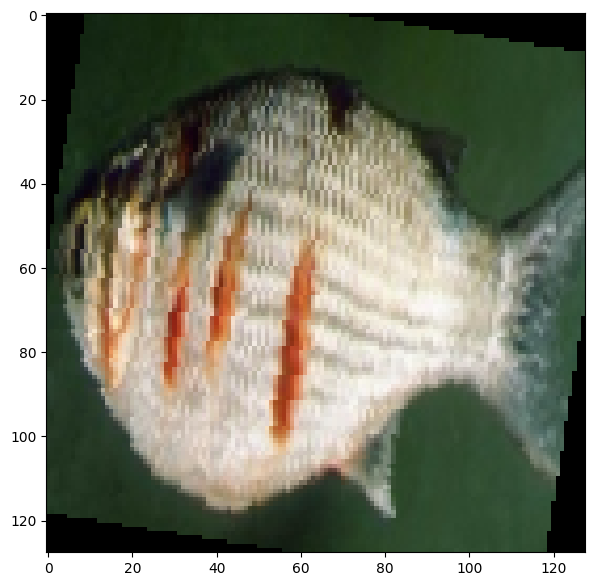

In [39]:
img_reshape = img.permute(1,2, 0)
print(f"original-shape,{img.shape}")
print(f"transformed-shape, {img_reshape.shape}")
plt.figure(figsize=(10,7))
plt.imshow(img_reshape)

In [40]:
train_dataloader = DataLoader(fish_train, batch_size=32, shuffle = True)
test_dataloader = DataLoader(fish_test, batch_size=32, shuffle= True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78576f663680>,
 <torch.utils.data.dataloader.DataLoader at 0x785762916330>)

In [ ]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


displaying the random images of the fishes using a helper function display random images

In [42]:
def display_random_images(dataset, class_names):
    random_samples_idx = random.sample(range(len(dataset)),6)
    plt.figure(figsize=(16,8))
    for i, sample_idx in enumerate(random_samples_idx):
        img, label = dataset[sample_idx][0], dataset[sample_idx][1]

        img_rearrange = img.permute(1,2, 0)

        plt.subplot(2,3,i+1)
        plt.imshow(img_rearrange)
        plt.axis("off")
        if class_names:
            title = f"class: {class_names[label]}"
        plt.title(title)

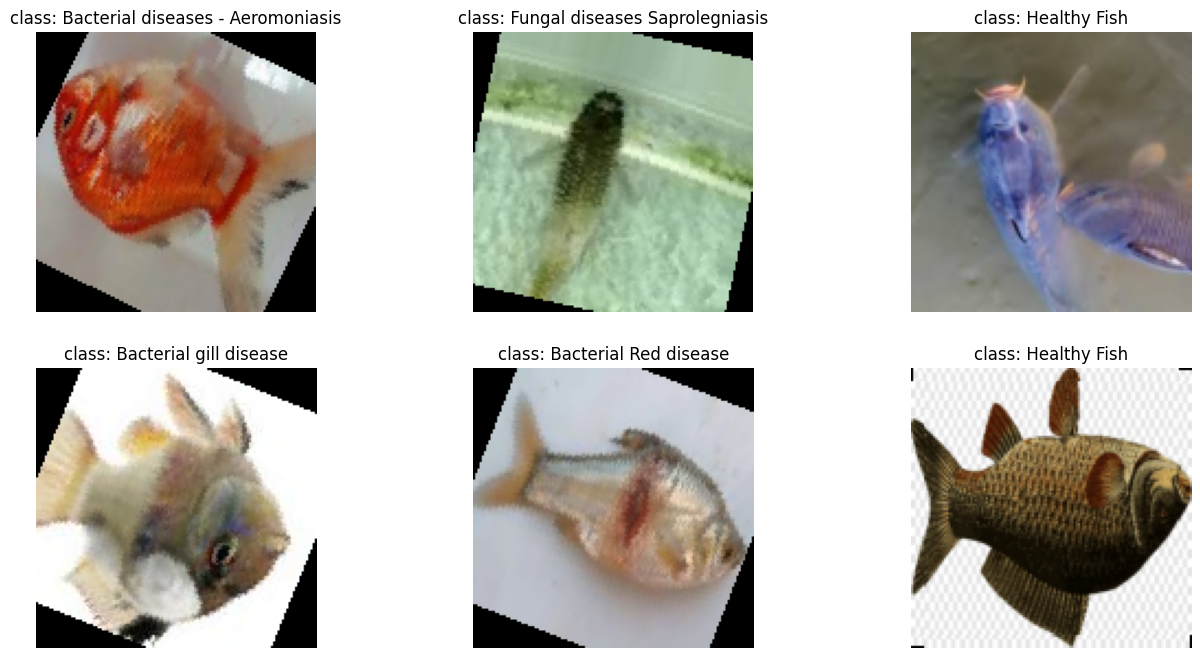

In [43]:
display_random_images(fish_train,class_fish)

Building the model a tiny model of CNN

In [44]:
class TinyCNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_shape,hidden_units, kernel_size = 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2 , stride=2),

            nn.Conv2d(hidden_units,hidden_units*2, kernel_size = 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units*2),
            nn.MaxPool2d(kernel_size=2 , stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*2*32*32, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(64, output_shape)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [45]:
model = TinyCNN(input_shape= 3, hidden_units= 32, output_shape=len(fish_train.classes)).to(device)

In [46]:
model

TinyCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [47]:
img, label = next(iter(train_dataloader))
img,label

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0

In [48]:
summary(model, input_size=[32, 3, 128,128])

Layer (type:depth-idx)                   Output Shape              Param #
TinyCNN                                  [32, 7]                   --
├─Sequential: 1-1                        [32, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 32, 128, 128]        896
│    └─ReLU: 2-2                         [32, 32, 128, 128]        --
│    └─BatchNorm2d: 2-3                  [32, 32, 128, 128]        64
│    └─MaxPool2d: 2-4                    [32, 32, 64, 64]          --
│    └─Conv2d: 2-5                       [32, 64, 64, 64]          18,496
│    └─ReLU: 2-6                         [32, 64, 64, 64]          --
│    └─BatchNorm2d: 2-7                  [32, 64, 64, 64]          128
│    └─MaxPool2d: 2-8                    [32, 64, 32, 32]          --
├─Sequential: 1-2                        [32, 7]                   --
│    └─Flatten: 2-9                      [32, 65536]               --
│    └─Linear: 2-10                      [32, 128]                 8,388,736
│ 

In [49]:
model.eval()
with torch.inference_mode():
    img = img.to(device)
    pred = model(img)
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label}")

Output logits:
tensor([[-0.0829, -0.0487,  0.0273, -0.0291,  0.0631,  0.1512,  0.0598],
        [-0.0877, -0.0468,  0.0319, -0.0389,  0.0648,  0.1568,  0.0661],
        [-0.0825, -0.0525,  0.0258, -0.0317,  0.0685,  0.1694,  0.0466],
        [-0.0817, -0.0538,  0.0265, -0.0418,  0.0723,  0.1693,  0.0562],
        [-0.0840, -0.0520,  0.0282, -0.0352,  0.0675,  0.1620,  0.0544],
        [-0.0816, -0.0478,  0.0268, -0.0316,  0.0655,  0.1615,  0.0613],
        [-0.0868, -0.0471,  0.0294, -0.0369,  0.0658,  0.1622,  0.0637],
        [-0.0782, -0.0447,  0.0288, -0.0305,  0.0709,  0.1554,  0.0615],
        [-0.0835, -0.0514,  0.0258, -0.0326,  0.0684,  0.1661,  0.0480],
        [-0.0820, -0.0455,  0.0270, -0.0339,  0.0721,  0.1685,  0.0502],
        [-0.0846, -0.0478,  0.0294, -0.0315,  0.0700,  0.1657,  0.0525],
        [-0.0820, -0.0467,  0.0271, -0.0302,  0.0751,  0.1573,  0.0559],
        [-0.0857, -0.0438,  0.0327, -0.0351,  0.0697,  0.1620,  0.0611],
        [-0.0798, -0.0440,  0.0273, 

In [50]:
epochs = 50
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

creating a train and test loop functions

In [51]:
def train_step(model, dataloader):
    train_loss ,train_acc =  0, 0
    for img, label in dataloader:
        img , label = img.to(device), label.to(device)
        outputs = model(img)
        loss = criteria(outputs, label)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        y_pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        train_acc += (y_pred_class == label).sum().item()/len(outputs)

    return train_loss/len(dataloader), train_acc/len(dataloader)

In [52]:
def test_step(model, dataloader):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for img, label in dataloader:
            img , label = img.to(device), label.to(device)
            outputs = model(img)
            loss = criteria(outputs, label)
            test_loss += loss.item()

            test_pred_labels = outputs.argmax(dim=1)
            test_acc += ((test_pred_labels == label).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

finally combining the function to train the model and test the model for certain number of epochs

In [53]:
def train_model(model, train_dataloader, test_dataloader):
    results = {
        "train_loss":[],
        "test_loss":[],
        "test_acc":[],
        "train_acc":[]
    }
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_dataloader)
        test_loss, test_acc = test_step(model, test_dataloader)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [54]:
results = train_model(model, train_dataloader, test_dataloader)

Epoch: 1 | train_loss: 1.9253 | train_acc: 0.1763 | test_loss: 1.8430 | test_acc: 0.2622
Epoch: 2 | train_loss: 1.8007 | train_acc: 0.2575 | test_loss: 1.7820 | test_acc: 0.2496
Epoch: 3 | train_loss: 1.6828 | train_acc: 0.3331 | test_loss: 1.6385 | test_acc: 0.3571
Epoch: 4 | train_loss: 1.5778 | train_acc: 0.3791 | test_loss: 1.4603 | test_acc: 0.4509
Epoch: 5 | train_loss: 1.5328 | train_acc: 0.4202 | test_loss: 1.4697 | test_acc: 0.4296
Epoch: 6 | train_loss: 1.4508 | train_acc: 0.4525 | test_loss: 1.3227 | test_acc: 0.5118
Epoch: 7 | train_loss: 1.3721 | train_acc: 0.4898 | test_loss: 1.2126 | test_acc: 0.5698
Epoch: 8 | train_loss: 1.2451 | train_acc: 0.5386 | test_loss: 1.0996 | test_acc: 0.6023
Epoch: 9 | train_loss: 1.1995 | train_acc: 0.5599 | test_loss: 1.0592 | test_acc: 0.6140
Epoch: 10 | train_loss: 1.1024 | train_acc: 0.5938 | test_loss: 1.0065 | test_acc: 0.6441
Epoch: 11 | train_loss: 1.0874 | train_acc: 0.6096 | test_loss: 0.9242 | test_acc: 0.6276
Epoch: 12 | train_l

In [56]:
results = pd.DataFrame({
    "epoch": range(1,epochs+1),
    "train_loss": results["train_loss"],
    "train_acc": results["train_acc"],
    "test_loss": results["test_loss"],
    "test_acc": results["test_acc"]
})
results.to_csv("training_logs.csv", index=False)

In [61]:
result_df = pd.read_csv("training_logs.csv")
result_df

,epoch,train_loss,train_acc,test_loss,test_acc
0,1,1.925281,0.176343,1.843002,0.262175
1,2,1.800686,0.257541,1.781997,0.249594
2,3,1.682819,0.333058,1.638511,0.357143
3,4,1.577760,0.379132,1.460327,0.450893
4,5,1.532820,0.420196,1.469733,0.429586
5,6,1.450808,0.452531,1.322743,0.511769
6,7,1.372112,0.489773,1.212568,0.569805
7,8,1.245100,0.538585,1.099552,0.602273
8,9,1.199534,0.559866,1.059241,0.614042
9,10,1.102425,0.593750,1.006532,0.644075


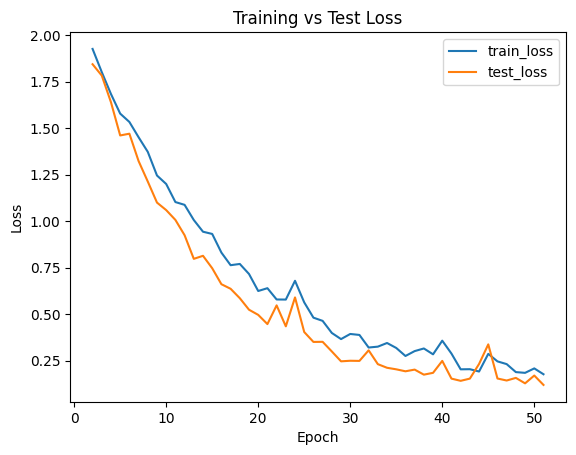

In [ ]:
plt.plot(result_df['epoch']+1,result_df['train_loss'], label="train_loss")
plt.plot(result_df['epoch']+1,result_df['test_loss'], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.show()

predicition on a custom image

In [72]:
custom_img = torchvision.io.read_image("fish-diseases/Test/Healthy Fish/Healthy Fish (1).jpeg").type(torch.float32)

In [73]:
custom_img

tensor([[[119., 117., 113.,  ...,  68.,  69.,  70.],
         [123., 124., 123.,  ...,  69.,  70.,  71.],
         [141., 141., 139.,  ...,  71.,  72.,  73.],
         ...,
         [ 24.,  24.,  31.,  ...,  35.,  35.,  35.],
         [ 33.,  32.,  39.,  ...,  35.,  35.,  35.],
         [ 36.,  35.,  42.,  ...,  35.,  35.,  35.]],

        [[105., 103.,  99.,  ..., 101., 102., 103.],
         [109., 110., 109.,  ..., 102., 103., 104.],
         [126., 126., 124.,  ..., 104., 105., 106.],
         ...,
         [ 24.,  24.,  31.,  ...,  35.,  35.,  35.],
         [ 33.,  32.,  39.,  ...,  35.,  35.,  35.],
         [ 36.,  35.,  42.,  ...,  35.,  35.,  35.]],

        [[ 58.,  56.,  54.,  ...,  90.,  91.,  92.],
         [ 64.,  65.,  64.,  ...,  91.,  92.,  93.],
         [ 83.,  83.,  81.,  ...,  93.,  94.,  95.],
         ...,
         [ 24.,  24.,  31.,  ...,  35.,  35.,  35.],
         [ 33.,  32.,  39.,  ...,  35.,  35.,  35.],
         [ 36.,  35.,  42.,  ...,  35.,  35.,  35.]]]

now the custom image needs to converted in the range of [0,1] as the model was trained on that range
so lets convert it into that range to make a prediction

In [74]:
custom_image = custom_img/255
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.4667, 0.4588, 0.4431,  ..., 0.2667, 0.2706, 0.2745],
         [0.4824, 0.4863, 0.4824,  ..., 0.2706, 0.2745, 0.2784],
         [0.5529, 0.5529, 0.5451,  ..., 0.2784, 0.2824, 0.2863],
         ...,
         [0.0941, 0.0941, 0.1216,  ..., 0.1373, 0.1373, 0.1373],
         [0.1294, 0.1255, 0.1529,  ..., 0.1373, 0.1373, 0.1373],
         [0.1412, 0.1373, 0.1647,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.4118, 0.4039, 0.3882,  ..., 0.3961, 0.4000, 0.4039],
         [0.4275, 0.4314, 0.4275,  ..., 0.4000, 0.4039, 0.4078],
         [0.4941, 0.4941, 0.4863,  ..., 0.4078, 0.4118, 0.4157],
         ...,
         [0.0941, 0.0941, 0.1216,  ..., 0.1373, 0.1373, 0.1373],
         [0.1294, 0.1255, 0.1529,  ..., 0.1373, 0.1373, 0.1373],
         [0.1412, 0.1373, 0.1647,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.2275, 0.2196, 0.2118,  ..., 0.3529, 0.3569, 0.3608],
         [0.2510, 0.2549, 0.2510,  ..., 0.3569, 0.3608, 0.3647],
         [0.3255, 0.3255, 0.3176,  ..

we need to transform our image as well right so lets quickly tranform our image

In [75]:
custom_image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
])

transformed_image = custom_image_transform(custom_image)
print(f"Transformed image shape: {transformed_image.shape}")

Transformed image shape: torch.Size([3, 128, 128])


In [79]:
model.eval()
with torch.inference_mode():
  custom_img_4d = transformed_image.unsqueeze(dim=0)
  print(f"Unsqueezed custom image shape: {custom_img_4d.shape}")
  output = model(custom_img_4d.to(device))

Unsqueezed custom image shape: torch.Size([1, 3, 128, 128])


In [80]:
output

tensor([[  6.8163,  -3.2865, -14.4152,   8.3680,  14.8159,  -7.0198,  -9.5569]],
       device='cuda:0')

In [81]:
print(f"Prediction logits: {output}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(output, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[  6.8163,  -3.2865, -14.4152,   8.3680,  14.8159,  -7.0198,  -9.5569]],
       device='cuda:0')
Prediction probabilities: tensor([[3.3494e-04, 1.3722e-08, 2.0150e-13, 1.5808e-03, 9.9808e-01, 3.2812e-10,
         2.5952e-11]], device='cuda:0')
Prediction label: tensor([4], device='cuda:0')


In [82]:
custom_pred_class = fish_train.classes[custom_image_pred_label]
custom_pred_class

'Healthy Fish'

pplotting the probabilities of the custom image prediction by our model

/tmp/ipython-input-1012149845.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


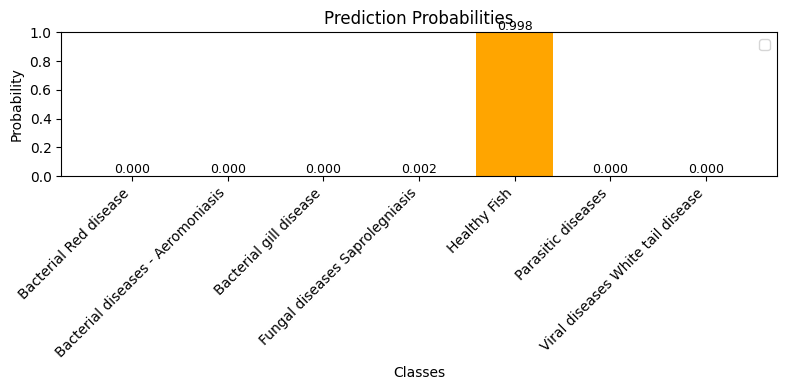

In [96]:
plt.figure(figsize=(8, 4))  # compact figure size

# Plot probabilities for each class
plt.bar(fish_train.classes, custom_image_pred_probs[0].cpu().numpy(), color='orange')
# Highlight predicted class
pred_class = torch.argmax(custom_image_pred_probs[0]).item()
# Add labels and title
plt.xlabel("Classes")
plt.ylabel("Probability")
plt.title("Prediction Probabilities")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
# Add value labels above bars
for i, v in enumerate(custom_image_pred_probs[0].cpu().numpy()):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()


building a custom function for displaying the prediction and the actual results predicted by our model of the random test data

In [118]:
def pred_and_plot_image(model, dataset):
    random_samples_idx = random.sample(range(len(dataset)), 12)
    plt.figure(figsize=(30, 10))

    for i, sample_idx in enumerate(random_samples_idx):
        img, label = dataset[sample_idx][0], dataset[sample_idx][1]
        model.eval()
        with torch.inference_mode():
            output = model(img.unsqueeze(0).to(device))
            custom_image_pred_probs = torch.softmax(output, dim=1)
            custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)

        plt.subplot(6, 2, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis("off")
        if custom_image_pred_label == label:
            plt.title(
                f"Actual: {dataset.classes[label]} | Pred: {dataset.classes[custom_image_pred_label]}",
                color="green"
            )
        else:
          plt.title(
            f"Actual: {dataset.classes[label]} | Pred: {dataset.classes[custom_image_pred_label]}",
            color="red"
        )

    plt.tight_layout(pad=2.0)
    plt.show()


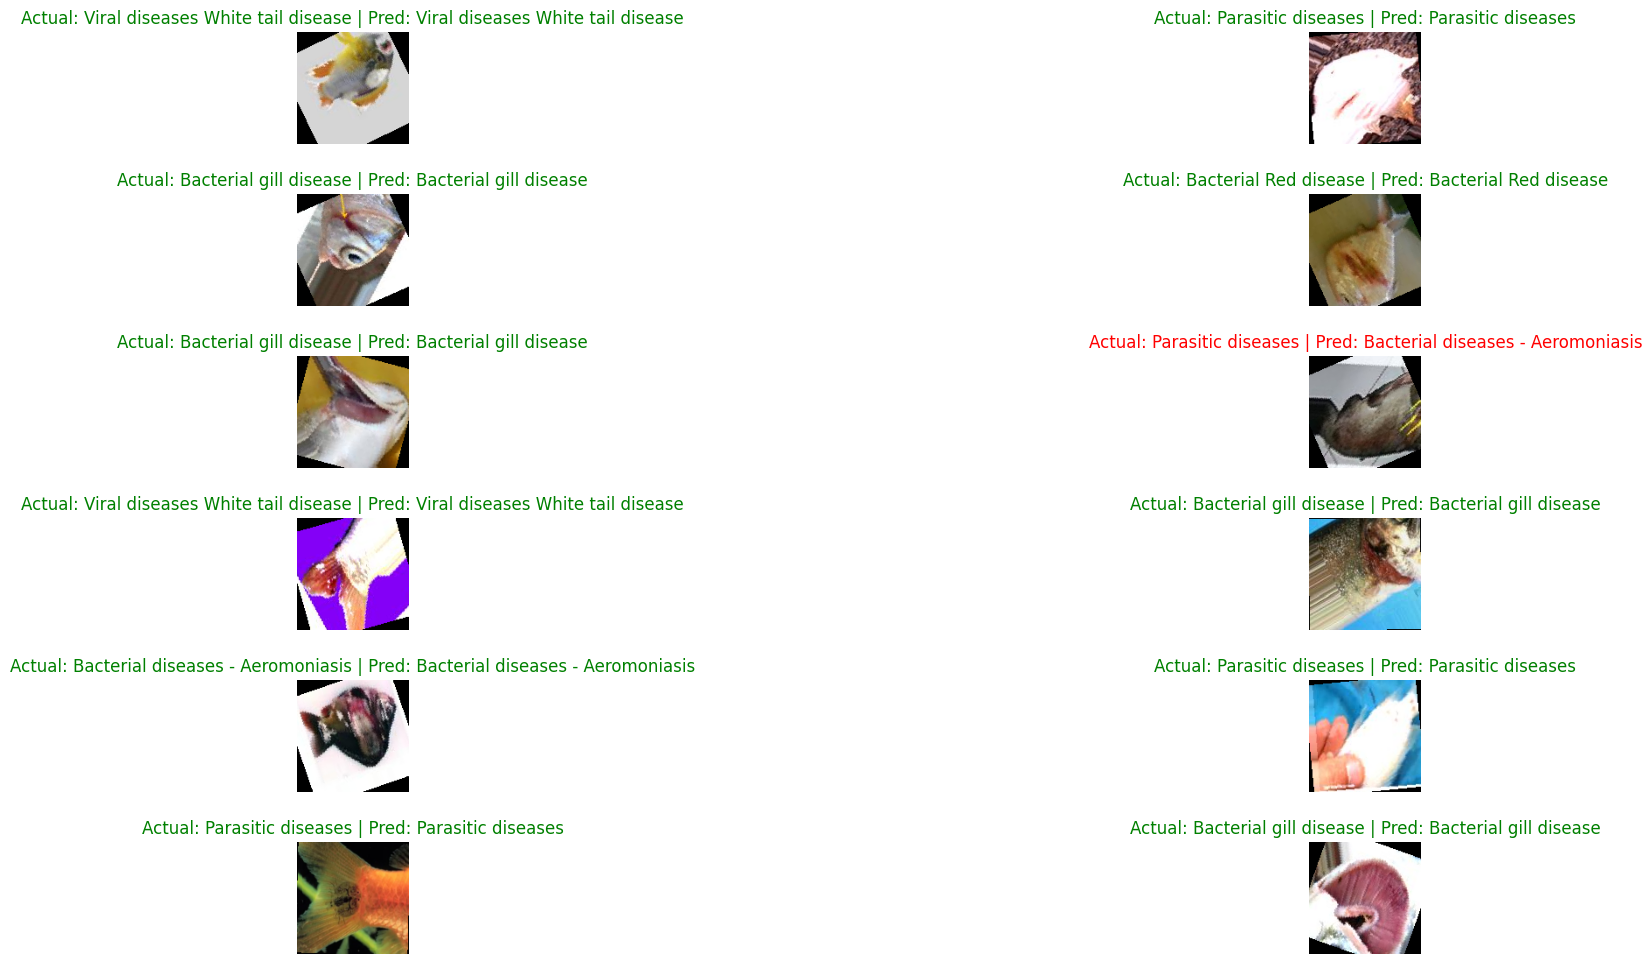

In [119]:
pred_and_plot_image(model, fish_train)

lets make a confusion matrix and to see our model's predictions

befor making confusion matrix lets actually get all the results from the model what actually the model has predicted

In [156]:
def get_all_preds(model, dataloader):
    all_pred_labels = []
    all_actual_labels = []
    model.eval()
    with torch.inference_mode():
        for img, label in dataloader:
            img , label = img.to(device), label.to(device)
            outputs = model(img)
            custom_image_pred_labels = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            all_pred_labels.append(custom_image_pred_labels.cpu())
            all_actual_labels.append(label.cpu())

    return torch.cat(all_pred_labels), torch.cat(all_actual_labels)

In [158]:
all_test_preds, all_actual_labels = get_all_preds(model, test_dataloader)
all_test_preds, all_actual_labels

(tensor([4, 2, 3, 5, 3, 4, 3, 1, 3, 4, 2, 3, 1, 1, 0, 2, 0, 0, 4, 6, 1, 2, 4, 5,
         0, 4, 0, 3, 0, 2, 3, 6, 4, 3, 0, 5, 1, 6, 0, 2, 6, 1, 1, 3, 0, 1, 2, 3,
         0, 3, 4, 1, 5, 1, 4, 4, 5, 3, 0, 4, 6, 2, 4, 4, 4, 1, 5, 5, 2, 6, 3, 2,
         3, 3, 6, 1, 0, 1, 4, 3, 1, 2, 6, 4, 2, 2, 1, 4, 2, 3, 6, 6, 5, 5, 2, 5,
         3, 5, 0, 1, 5, 2, 1, 0, 0, 0, 2, 6, 0, 5, 0, 4, 5, 4, 0, 1, 4, 3, 6, 0,
         6, 6, 5, 3, 5, 6, 5, 6, 6, 4, 4, 0, 0, 5, 1, 3, 5, 5, 2, 5, 0, 1, 6, 1,
         4, 1, 5, 0, 5, 2, 4, 2, 6, 4, 1, 1, 6, 4, 4, 5, 5, 0, 6, 4, 5, 0, 0, 1,
         0, 6, 4, 2, 2, 6, 1, 4, 0, 6, 0, 5, 1, 3, 4, 5, 5, 3, 2, 1, 0, 3, 2, 2,
         5, 4, 2, 6, 5, 0, 4, 0, 1, 3, 6, 5, 6, 2, 0, 6, 1, 1, 5, 2, 2, 6, 3, 4,
         3, 1, 5, 4, 3, 6, 1, 1, 2, 6, 0, 2, 5, 5, 2, 6, 1, 0, 1, 0, 3, 5, 5, 2,
         2, 0, 3, 1, 6, 3, 4, 3, 4, 6, 1, 5, 1, 2, 5, 0, 1, 5, 1, 4, 5, 4, 1, 4,
         6, 1, 6, 1, 4, 5, 5, 4, 1, 3, 3, 1, 4, 3, 3, 0, 6, 2, 1, 4, 6, 3, 0, 4,
         4, 5, 4, 2, 1, 5, 6

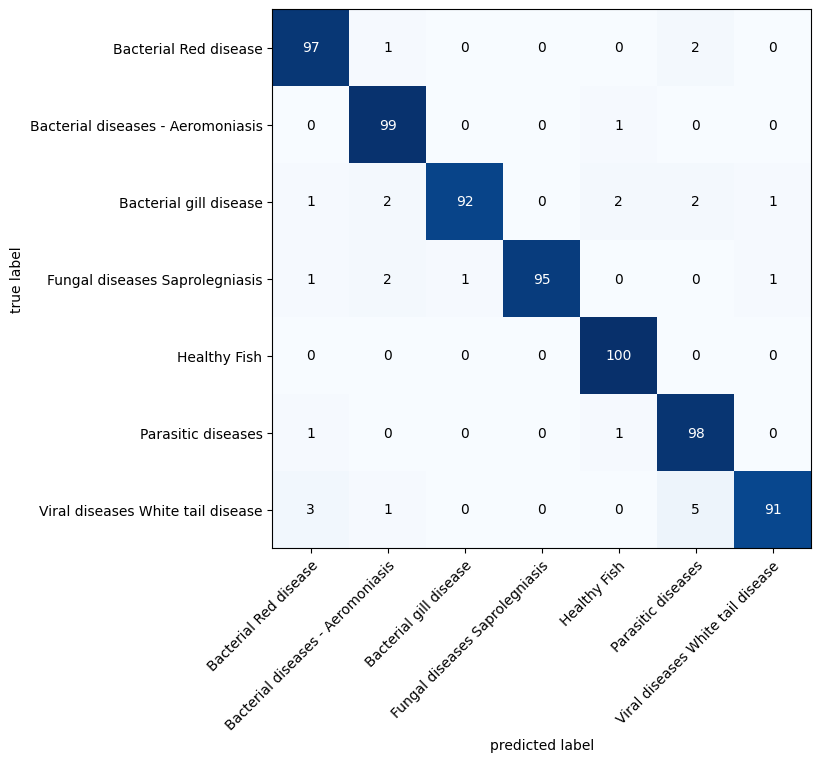

In [159]:
confmat = ConfusionMatrix(num_classes=len(fish_test.classes), task='multiclass')
confmat_tensor = confmat(preds=all_test_preds,target=all_actual_labels)
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=fish_test.classes, # turn the row and column labels into class names
    figsize=(10, 7)
);

saving our model

In [160]:
save = torch.save(model.state_dict(), "fish_model.pth")